## Import Premier League, League 1, La Liga Data and perform basic cleaning

In [58]:
import numpy as np
import pandas as pd
from pathlib import Path

# Resolve data directory relative to the notebook location (../data)
data_dir = (Path.cwd().parent / "data").resolve()
processed_dir = data_dir / "processed"

# Helper to choose processed file first, else fallback raw by league code
def resolve_league_path(league_code: str) -> str:
    processed_file = processed_dir / f"{league_code}_combined.csv"
    raw_fallback = {
        "ENG": data_dir / "premier_league_matches.csv",
        "FRA": data_dir / "league1_matches.csv",
        "SPA": data_dir / "la_liga_matches.csv",
    }.get(league_code)

    if processed_file.exists():
        return str(processed_file)
    if raw_fallback and raw_fallback.exists():
        return str(raw_fallback)
    raise FileNotFoundError(
        f"Data file not found for {league_code}. Expected: {processed_file} or {raw_fallback}.\n"
        f"Run merge_datasets.py to create processed files."
    )

# Load all requested leagues
leagues = ["ENG", "FRA", "SPA"]
league_dfs = {}
for code in leagues:
    path = resolve_league_path(code)
    df = pd.read_csv(path)
    df = df[df["Minute"] > 0]
    league_dfs[code] = df

# Unpack for convenience
premier_league_df = league_dfs["ENG"]
league1_df = league_dfs["FRA"]
laliga_df = league_dfs["SPA"]

print("Loaded leagues:", ", ".join(league_dfs.keys()))
print(f"ENG columns: {premier_league_df.columns.tolist()}")
print(f"FRA columns: {league1_df.columns.tolist()}")
print(f"SPA columns: {laliga_df.columns.tolist()}")

Loaded leagues: ENG, FRA, SPA
ENG columns: ['RBallID', 'HomeTeam', 'AwayTeam', 'Timestamp', 'Incident', 'IncidentNumber', 'Minute']
FRA columns: ['RBallID', 'HomeTeam', 'AwayTeam', 'Timestamp', 'Incident', 'IncidentNumber', 'Minute']
SPA columns: ['RBallID', 'HomeTeam', 'AwayTeam', 'Timestamp', 'Incident', 'IncidentNumber', 'Minute']


## Descriptive Statistics Analysis

In [59]:
def create_descriptive_stats(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create descriptive statistics for match game data.

    Parameters:
    df (pd.DataFrame): DataFrame containing match game statistics.

    Returns:
    pd.DataFrame: Descriptive statistics excluding count and RBallID.
    """
    stats = {
    "goals": (df["Incident"] == "GOAL1") | (df["Incident"] == "GOAL2"),
    "corners": (df["Incident"] == "CR1") | (df["Incident"] == "CR2"),
    "shots_on_target": (df['Incident'] == 'SHG1') | (df['Incident'] == 'SHG2'),
    "fouls": (df['Incident'] == 'F1') | (df['Incident'] == 'F2'),
    "offsides": (df['Incident'] == 'O1') | (df['Incident'] == 'O2'),
    "penalties": (df['Incident'] == 'PEN1') | (df['Incident'] == 'PEN2'),
    "shots_blocked": (df['Incident'] == 'BLOCKED1') | (df['Incident'] == 'BLOCKED2'),
    "goal_kicks": (df['Incident'] == 'GK1') | (df['Incident'] == 'GK2'),
    "shots_off_target": (df['Incident'] == 'SHB1') | (df['Incident'] == 'SHB2'),
    "throwins": (df['Incident'] == 'TI1') | (df['Incident'] == 'TI2'),
    "shots_woodwork": (df['Incident'] == 'SHW1') | (df['Incident'] == 'SHW2'),
    }
    
    for name, mask in stats.items():
        df[name] = mask
    agg_cols = list(stats.keys())

    match_game = (
        df.groupby("RBallID")[agg_cols].
        sum().
        reset_index()
    )
    match_game["total_incidents"] = df.groupby("RBallID").size().values
    match_game["offensive_incidents"] = match_game["goals"] + match_game["shots_on_target"] + match_game["shots_off_target"] + match_game["shots_woodwork"] + match_game["penalties"] + match_game["corners"] + match_game["offsides"] + match_game["shots_blocked"]
    match_game["defensive_incidents"] = match_game["fouls"] + match_game["goal_kicks"] + match_game["throwins"]

    desc = match_game.describe().drop(index="count").drop(columns="RBallID").round(2)
    return desc,match_game

df1 = premier_league_df.copy()
df2 = league1_df.copy()
df3 = laliga_df.copy()
stats_premier, match_premier = create_descriptive_stats(df1)
stats_league1, match_league1 = create_descriptive_stats(df2)
stats_laliga, match_laliga = create_descriptive_stats(df3)


In [64]:
print("Premier League Descriptive Statistics:\n", stats_premier)

Premier League Descriptive Statistics:
       goals  corners  shots_on_target  fouls  offsides  penalties  \
mean   3.00    10.46             7.05  20.06      3.93       0.24   
std    1.66     3.37             3.12   5.01      2.31       0.49   
min    0.00     2.00             0.00   4.00      0.00       0.00   
25%    2.00     8.00             5.00  17.00      2.00       0.00   
50%    3.00    10.00             7.00  20.00      4.00       0.00   
75%    4.00    13.00             9.00  23.00      5.00       0.00   
max    9.00    21.00            25.00  36.00     13.00       3.00   

      shots_blocked  goal_kicks  shots_off_target  throwins  shots_woodwork  \
mean           3.63       15.78              9.24     44.58            0.49   
std            2.31        3.87              3.16      9.78            0.69   
min            0.00        4.00              1.00     13.00            0.00   
25%            2.00       13.00              7.00     38.00            0.00   
50%         

In [62]:
print("\nLeague 1 Descriptive Statistics:\n", stats_league1)

League 1 Descriptive Statistics:
       goals  corners  shots_on_target  fouls  offsides  penalties  \
mean   2.87     9.73             7.22  25.50      3.36       0.36   
std    1.67     3.32             3.10   5.66      2.15       0.59   
min    0.00     2.00             0.00   1.00      0.00       0.00   
25%    2.00     7.00             5.00  22.00      2.00       0.00   
50%    3.00     9.00             7.00  25.00      3.00       0.00   
75%    4.00    12.00             9.00  29.00      5.00       1.00   
max    9.00    23.00            18.00  47.00     12.00       4.00   

      shots_blocked  goal_kicks  shots_off_target  throwins  shots_woodwork  \
mean           2.82       16.19              9.99     45.53            0.56   
std            2.07        3.77              3.28     10.01            0.77   
min            0.00        3.00              1.00     13.00            0.00   
25%            1.00       14.00              8.00     38.00            0.00   
50%            3.0

In [66]:
print("La Liga Descriptive Statistics:\n", stats_laliga)


La Liga Descriptive Statistics:
       goals  corners  shots_on_target  fouls  offsides  penalties  \
mean   2.98     9.72             7.24  26.78      4.52       0.35   
std    1.83     3.25             3.12   5.92      2.63       0.60   
min    0.00     1.00             1.00  11.00      0.00       0.00   
25%    2.00     7.00             5.00  23.00      3.00       0.00   
50%    3.00    10.00             7.00  26.00      4.00       0.00   
75%    4.00    12.00             9.00  30.50      6.00       1.00   
max   10.00    20.00            19.00  50.00     17.00       3.00   

      shots_blocked  goal_kicks  shots_off_target  throwins  shots_woodwork  \
mean           2.76       16.07              9.95     42.38             0.6   
std            1.88        4.08              3.69      9.94             0.8   
min            0.00        4.00              1.00     18.00             0.0   
25%            1.00       13.00              8.00     35.00             0.0   
50%            2.00

# Explore correlation between statistics in each league

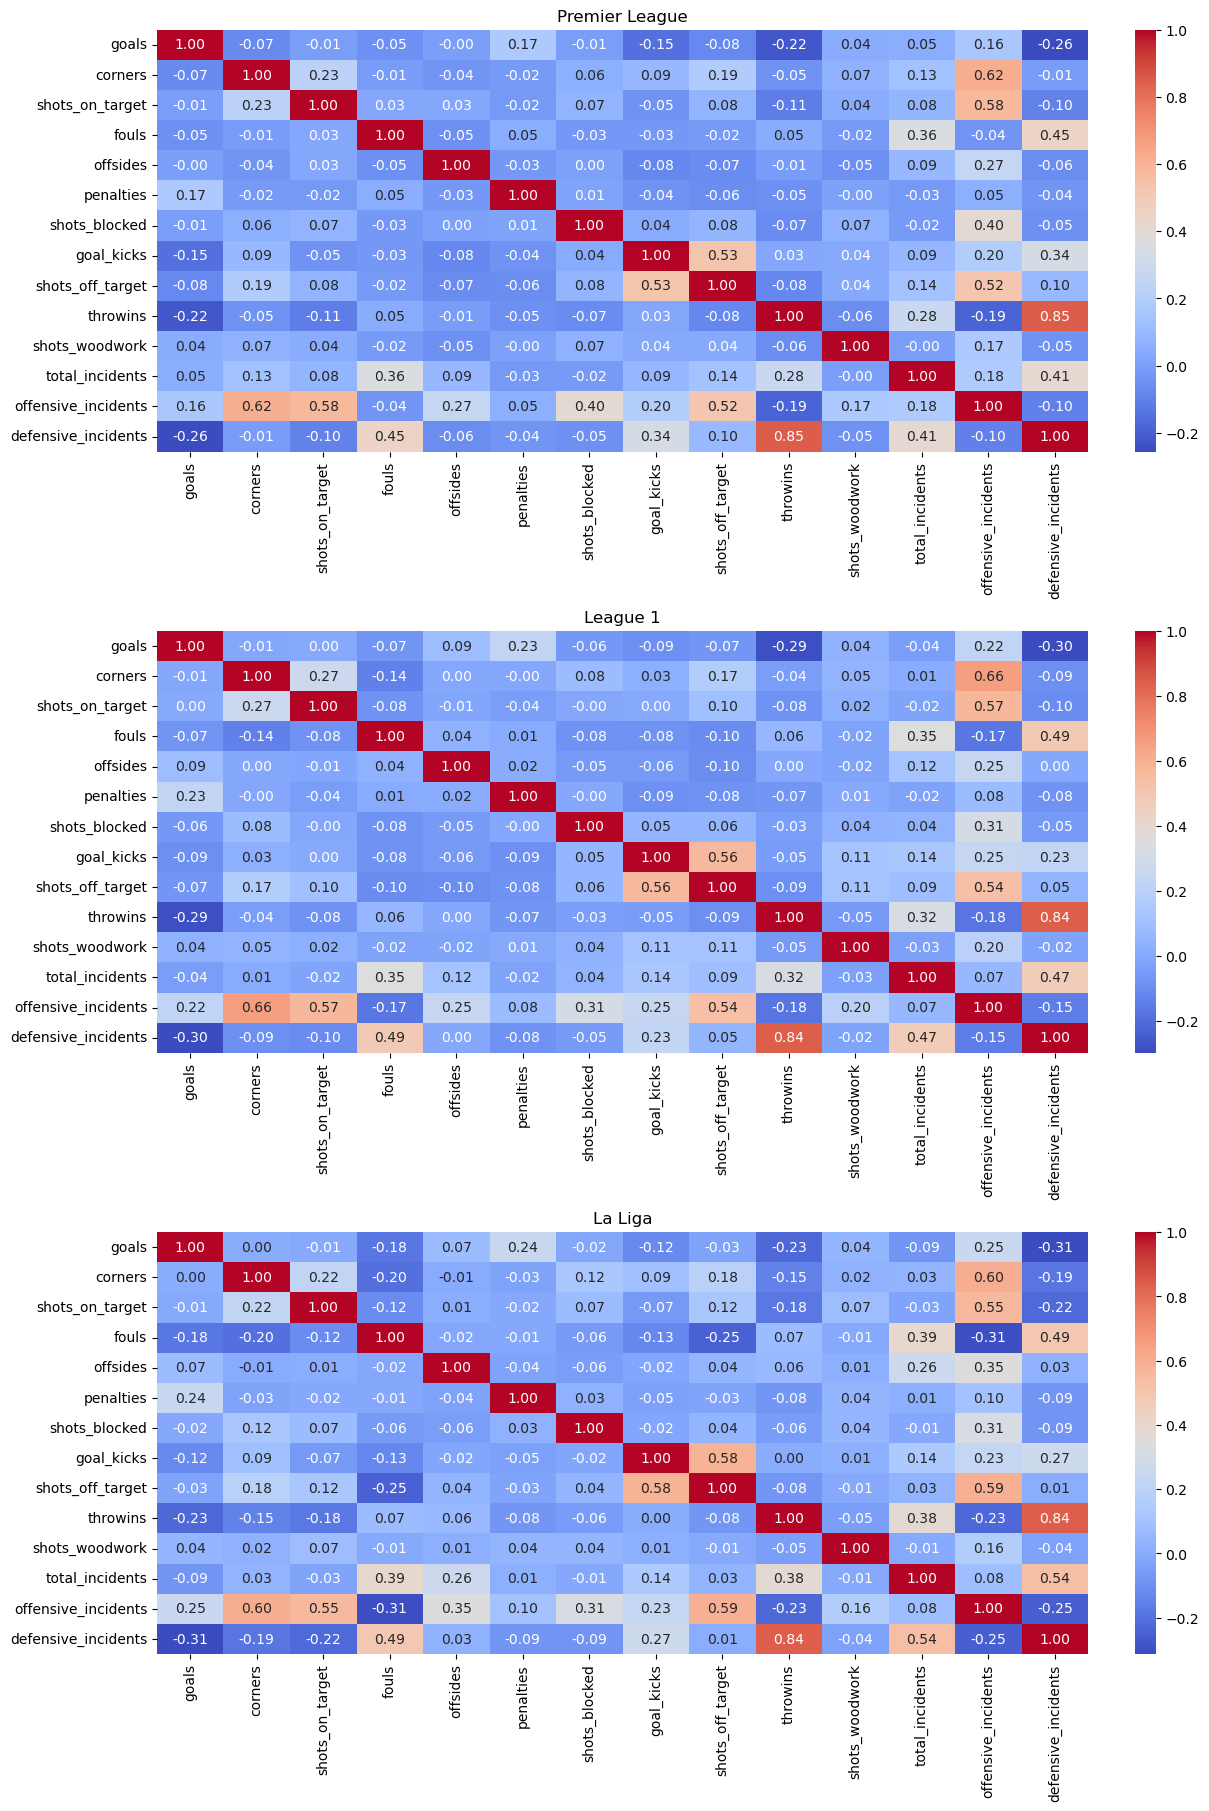

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
leagues = [match_premier, match_league1, match_laliga]
labels = ["Premier League", "League 1", "La Liga"]

fig, axes = plt.subplots(3, 1, figsize=(12, 18), constrained_layout=True)
for ax, league_df, title in zip(axes, leagues, labels):
    corr = league_df.drop(columns="RBallID").corr()
    sns.heatmap(corr, ax=ax, annot=True, fmt=".2f", cmap="coolwarm")
    ax.set_title(title)

plt.show()

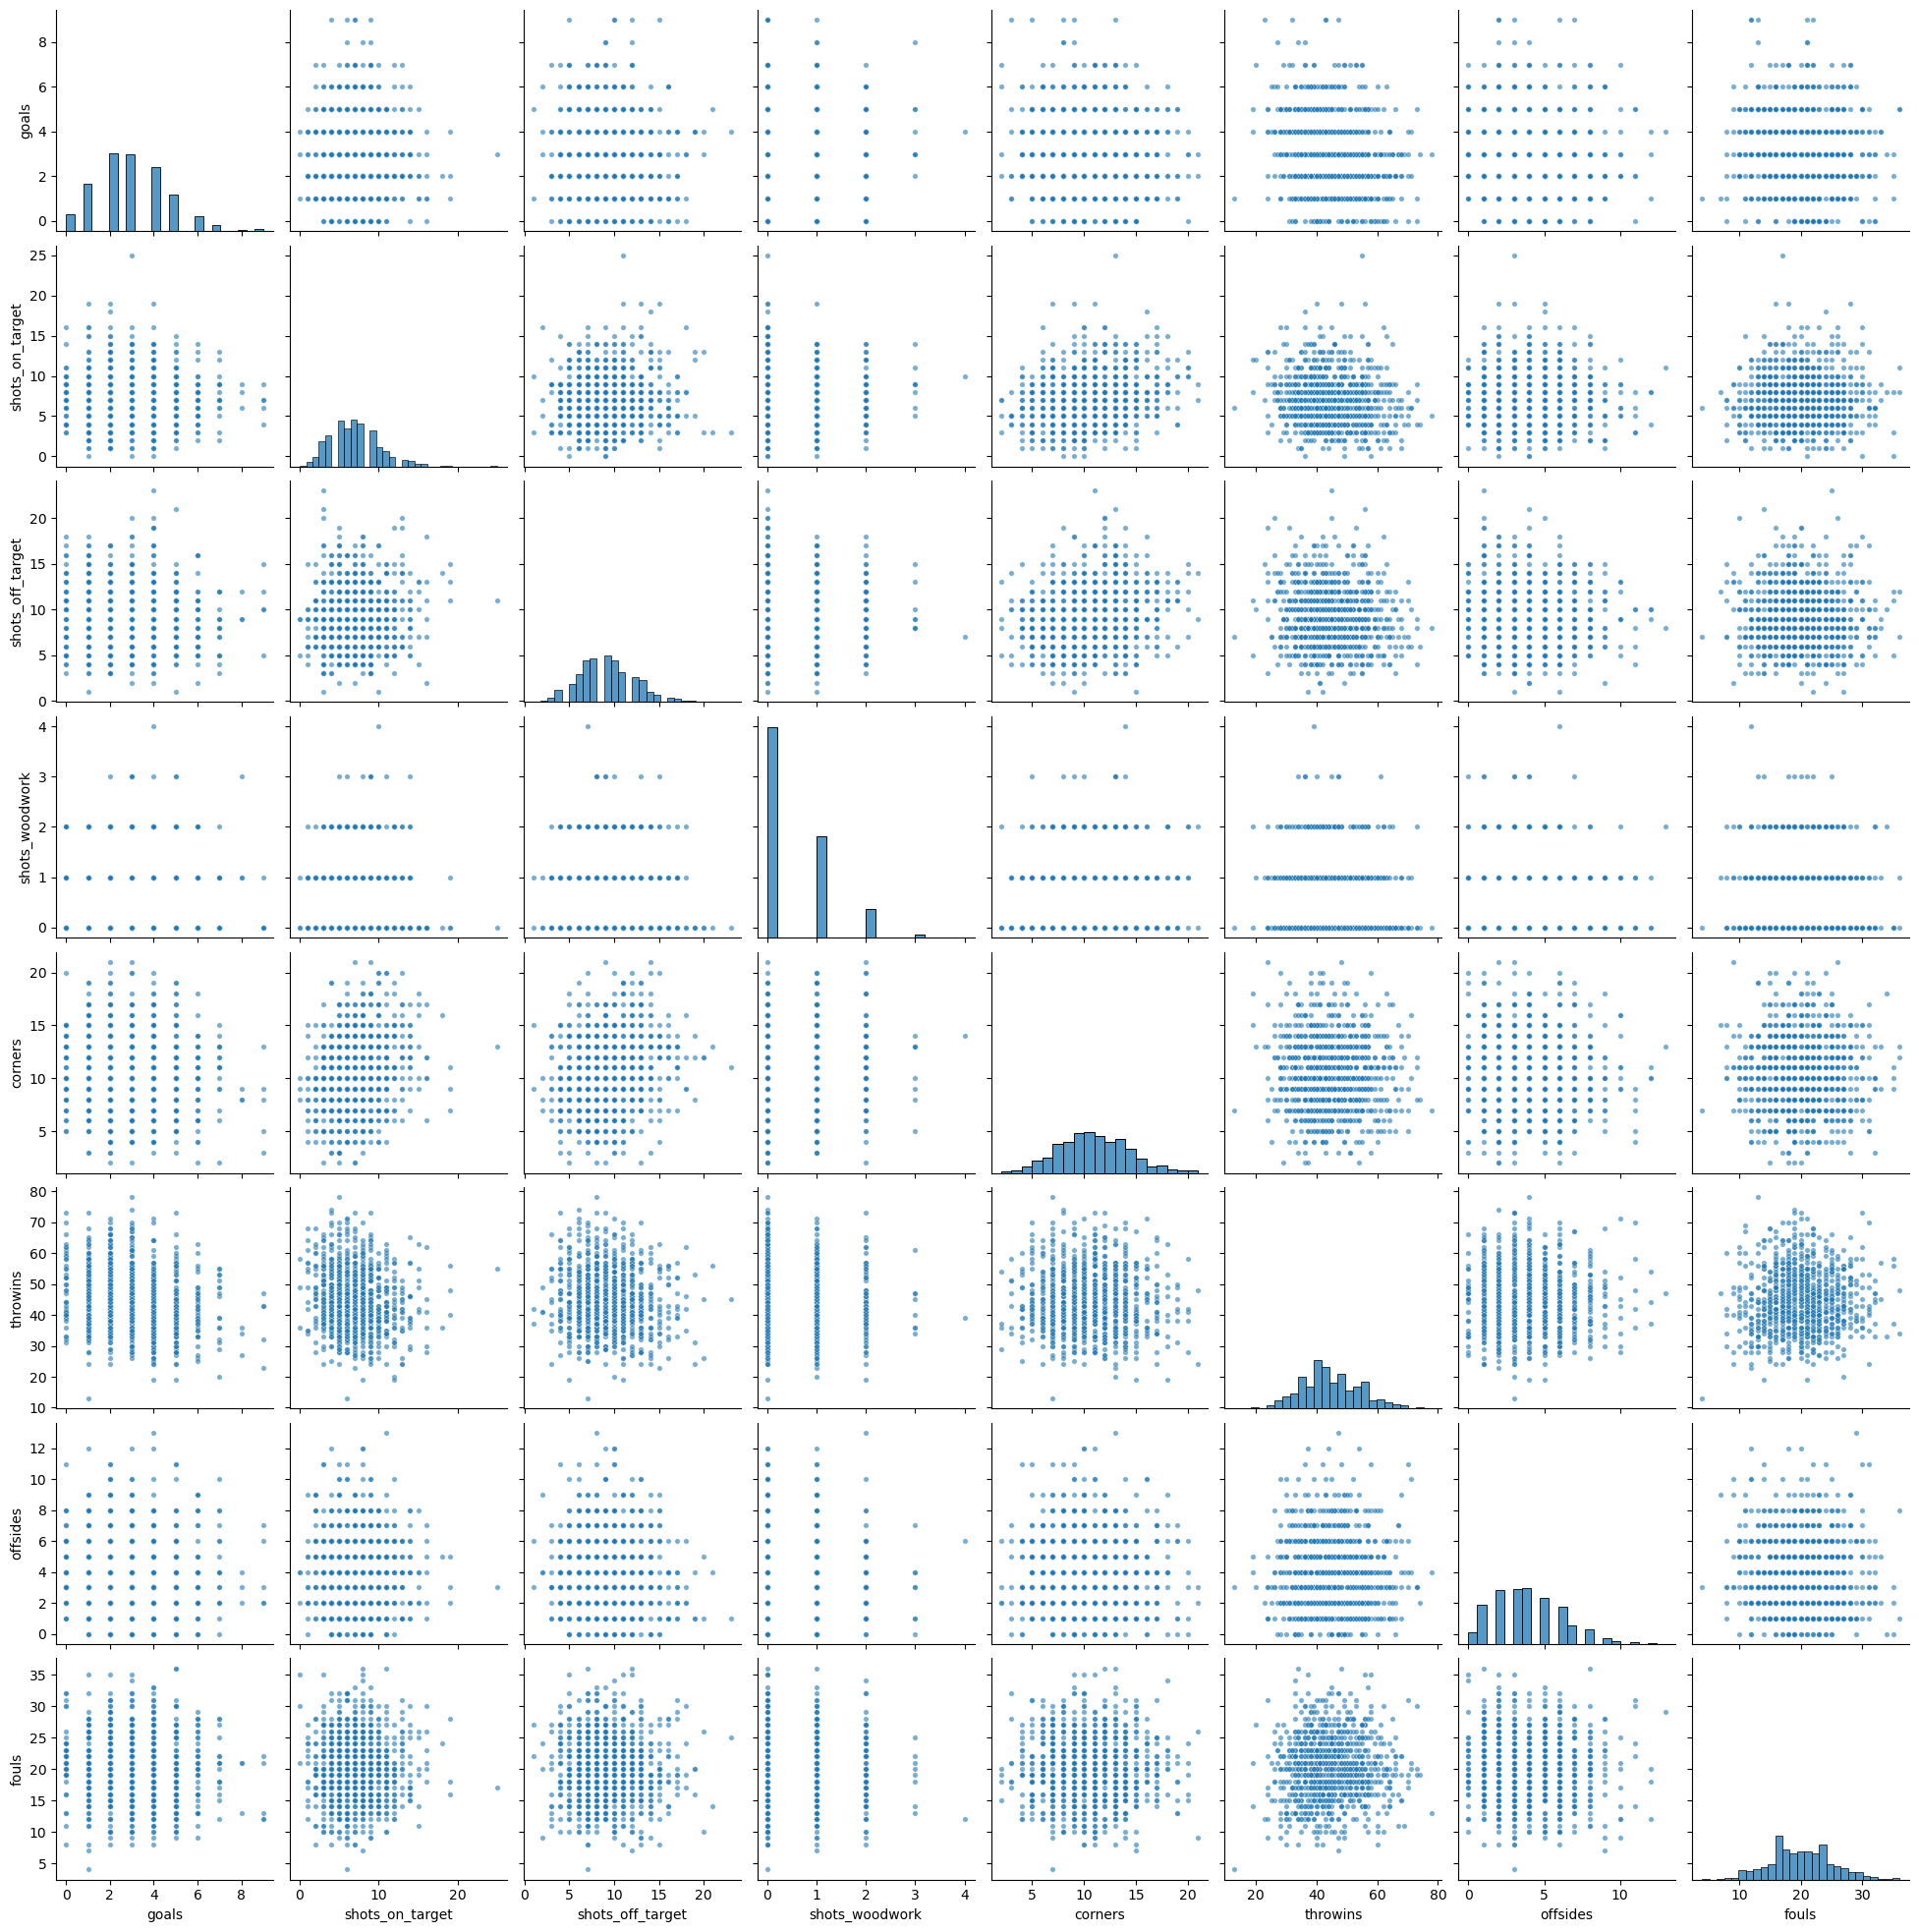

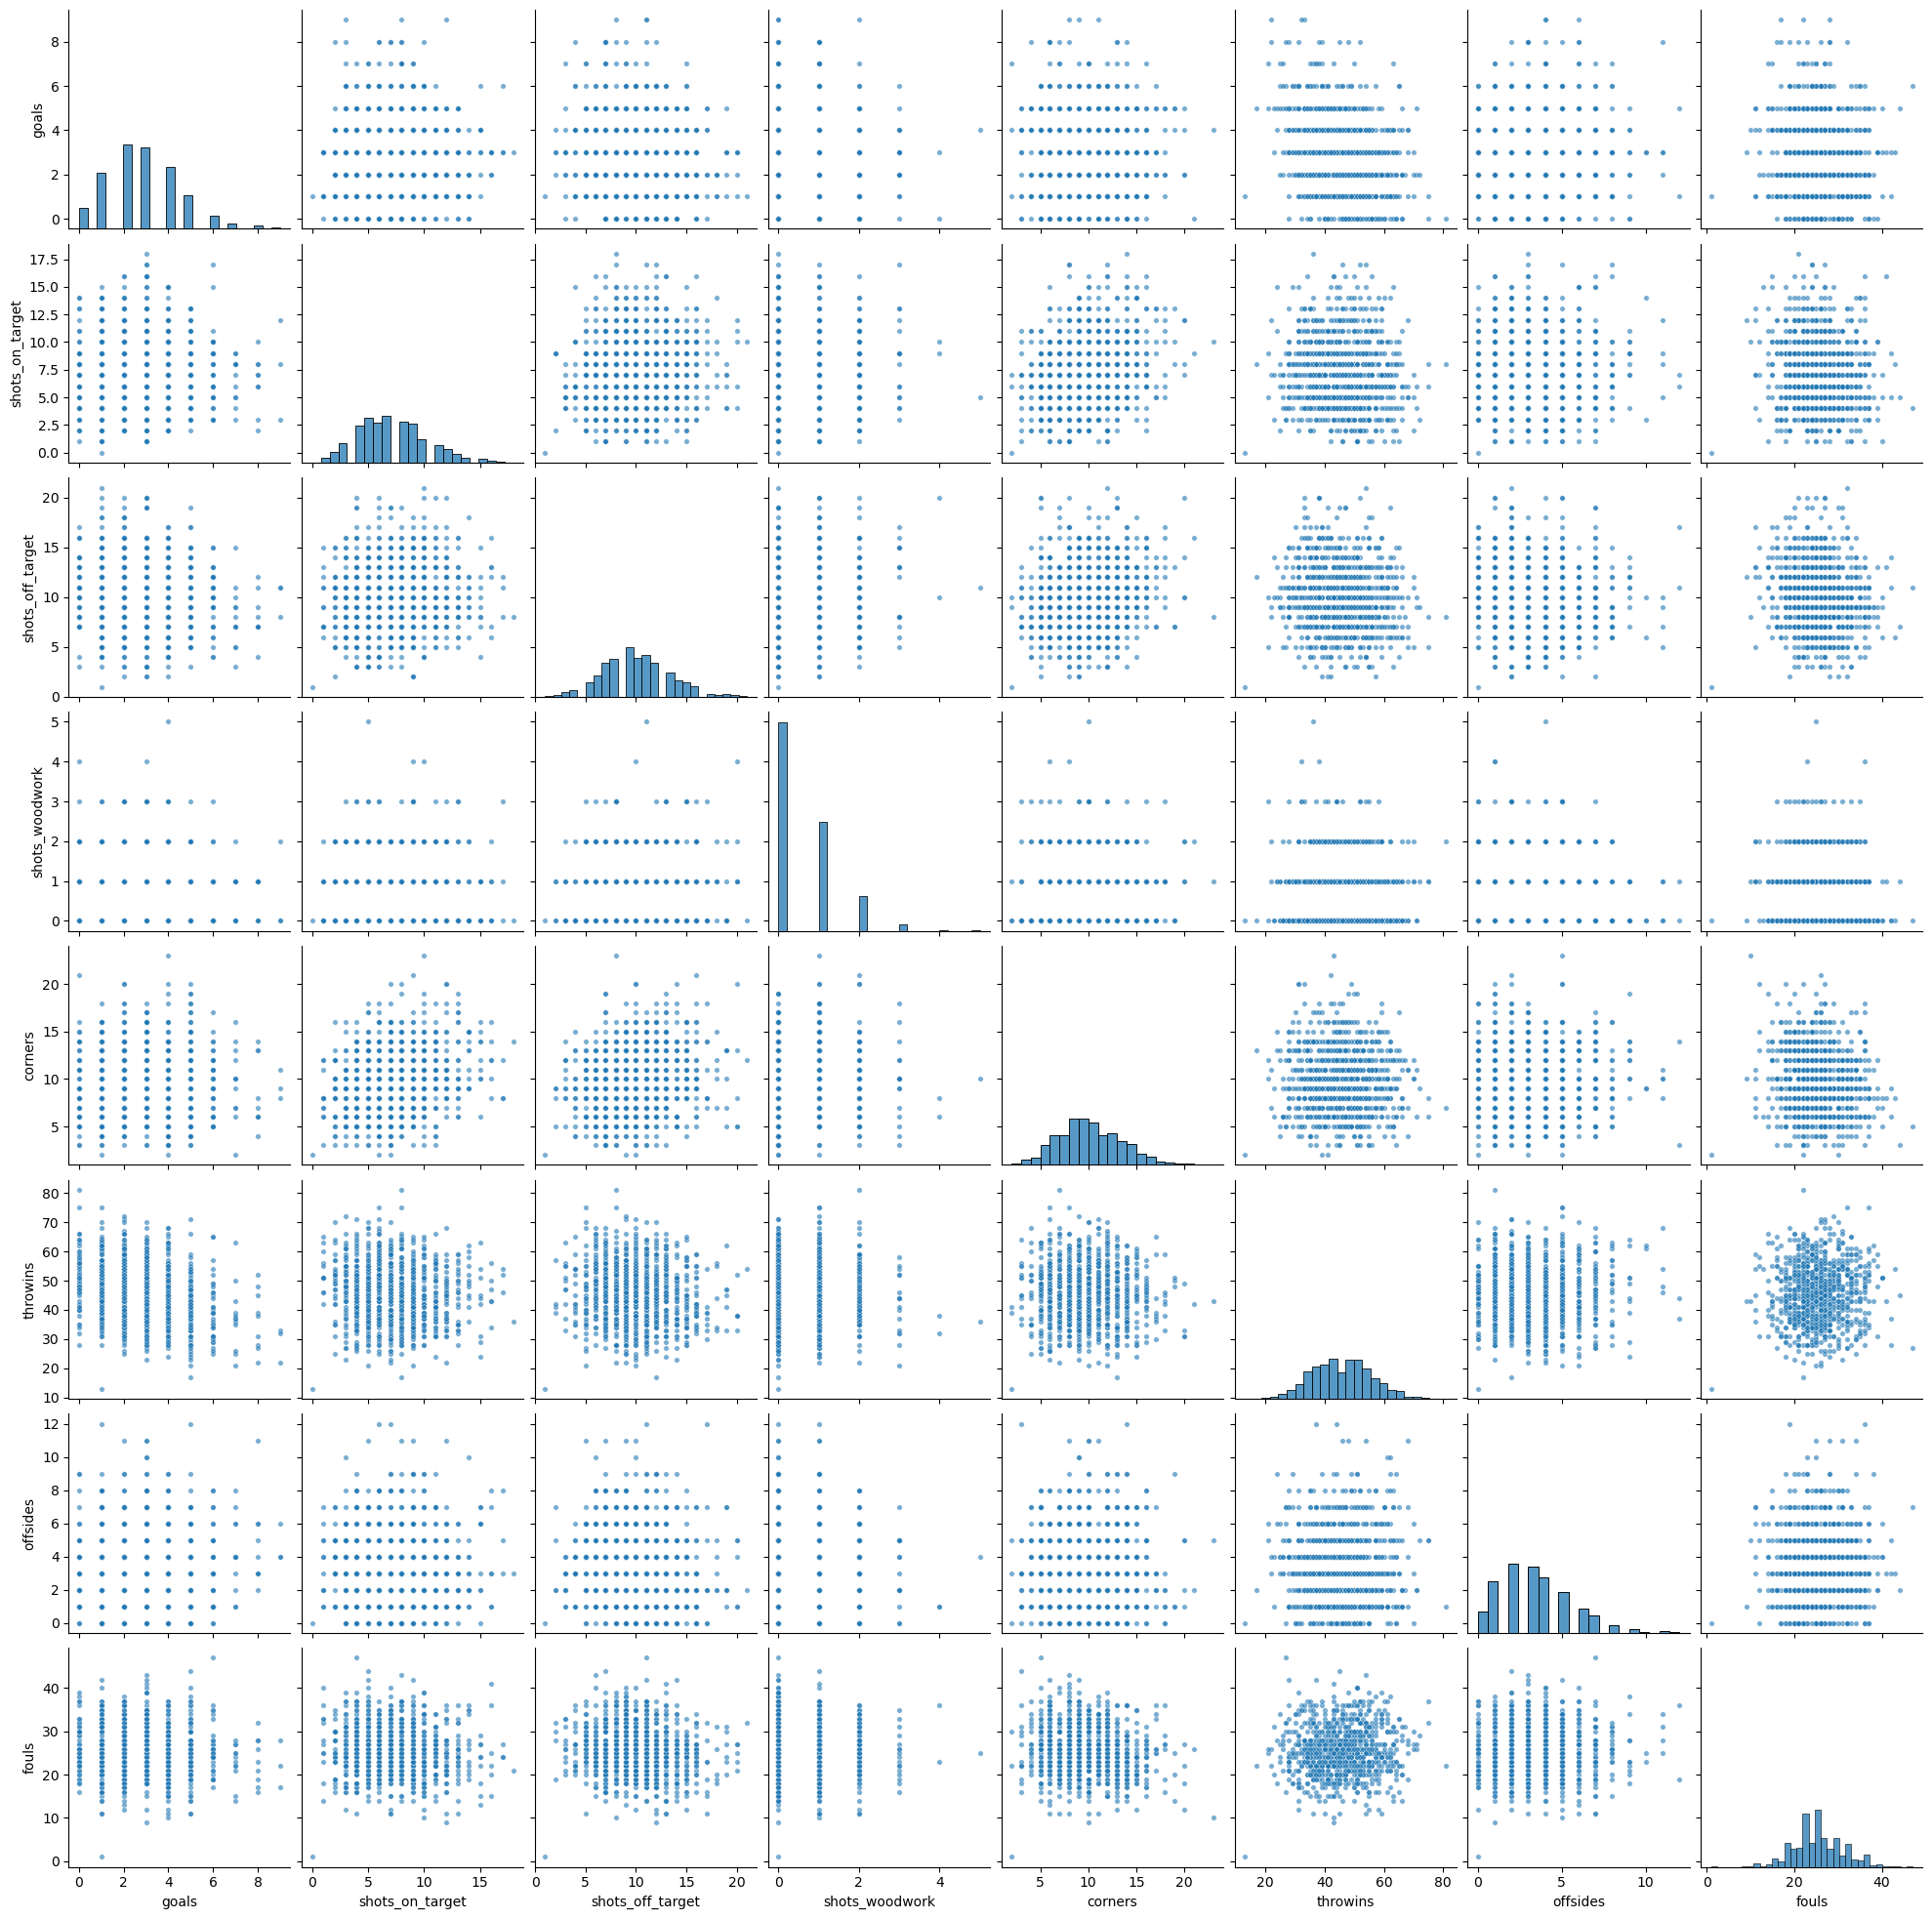

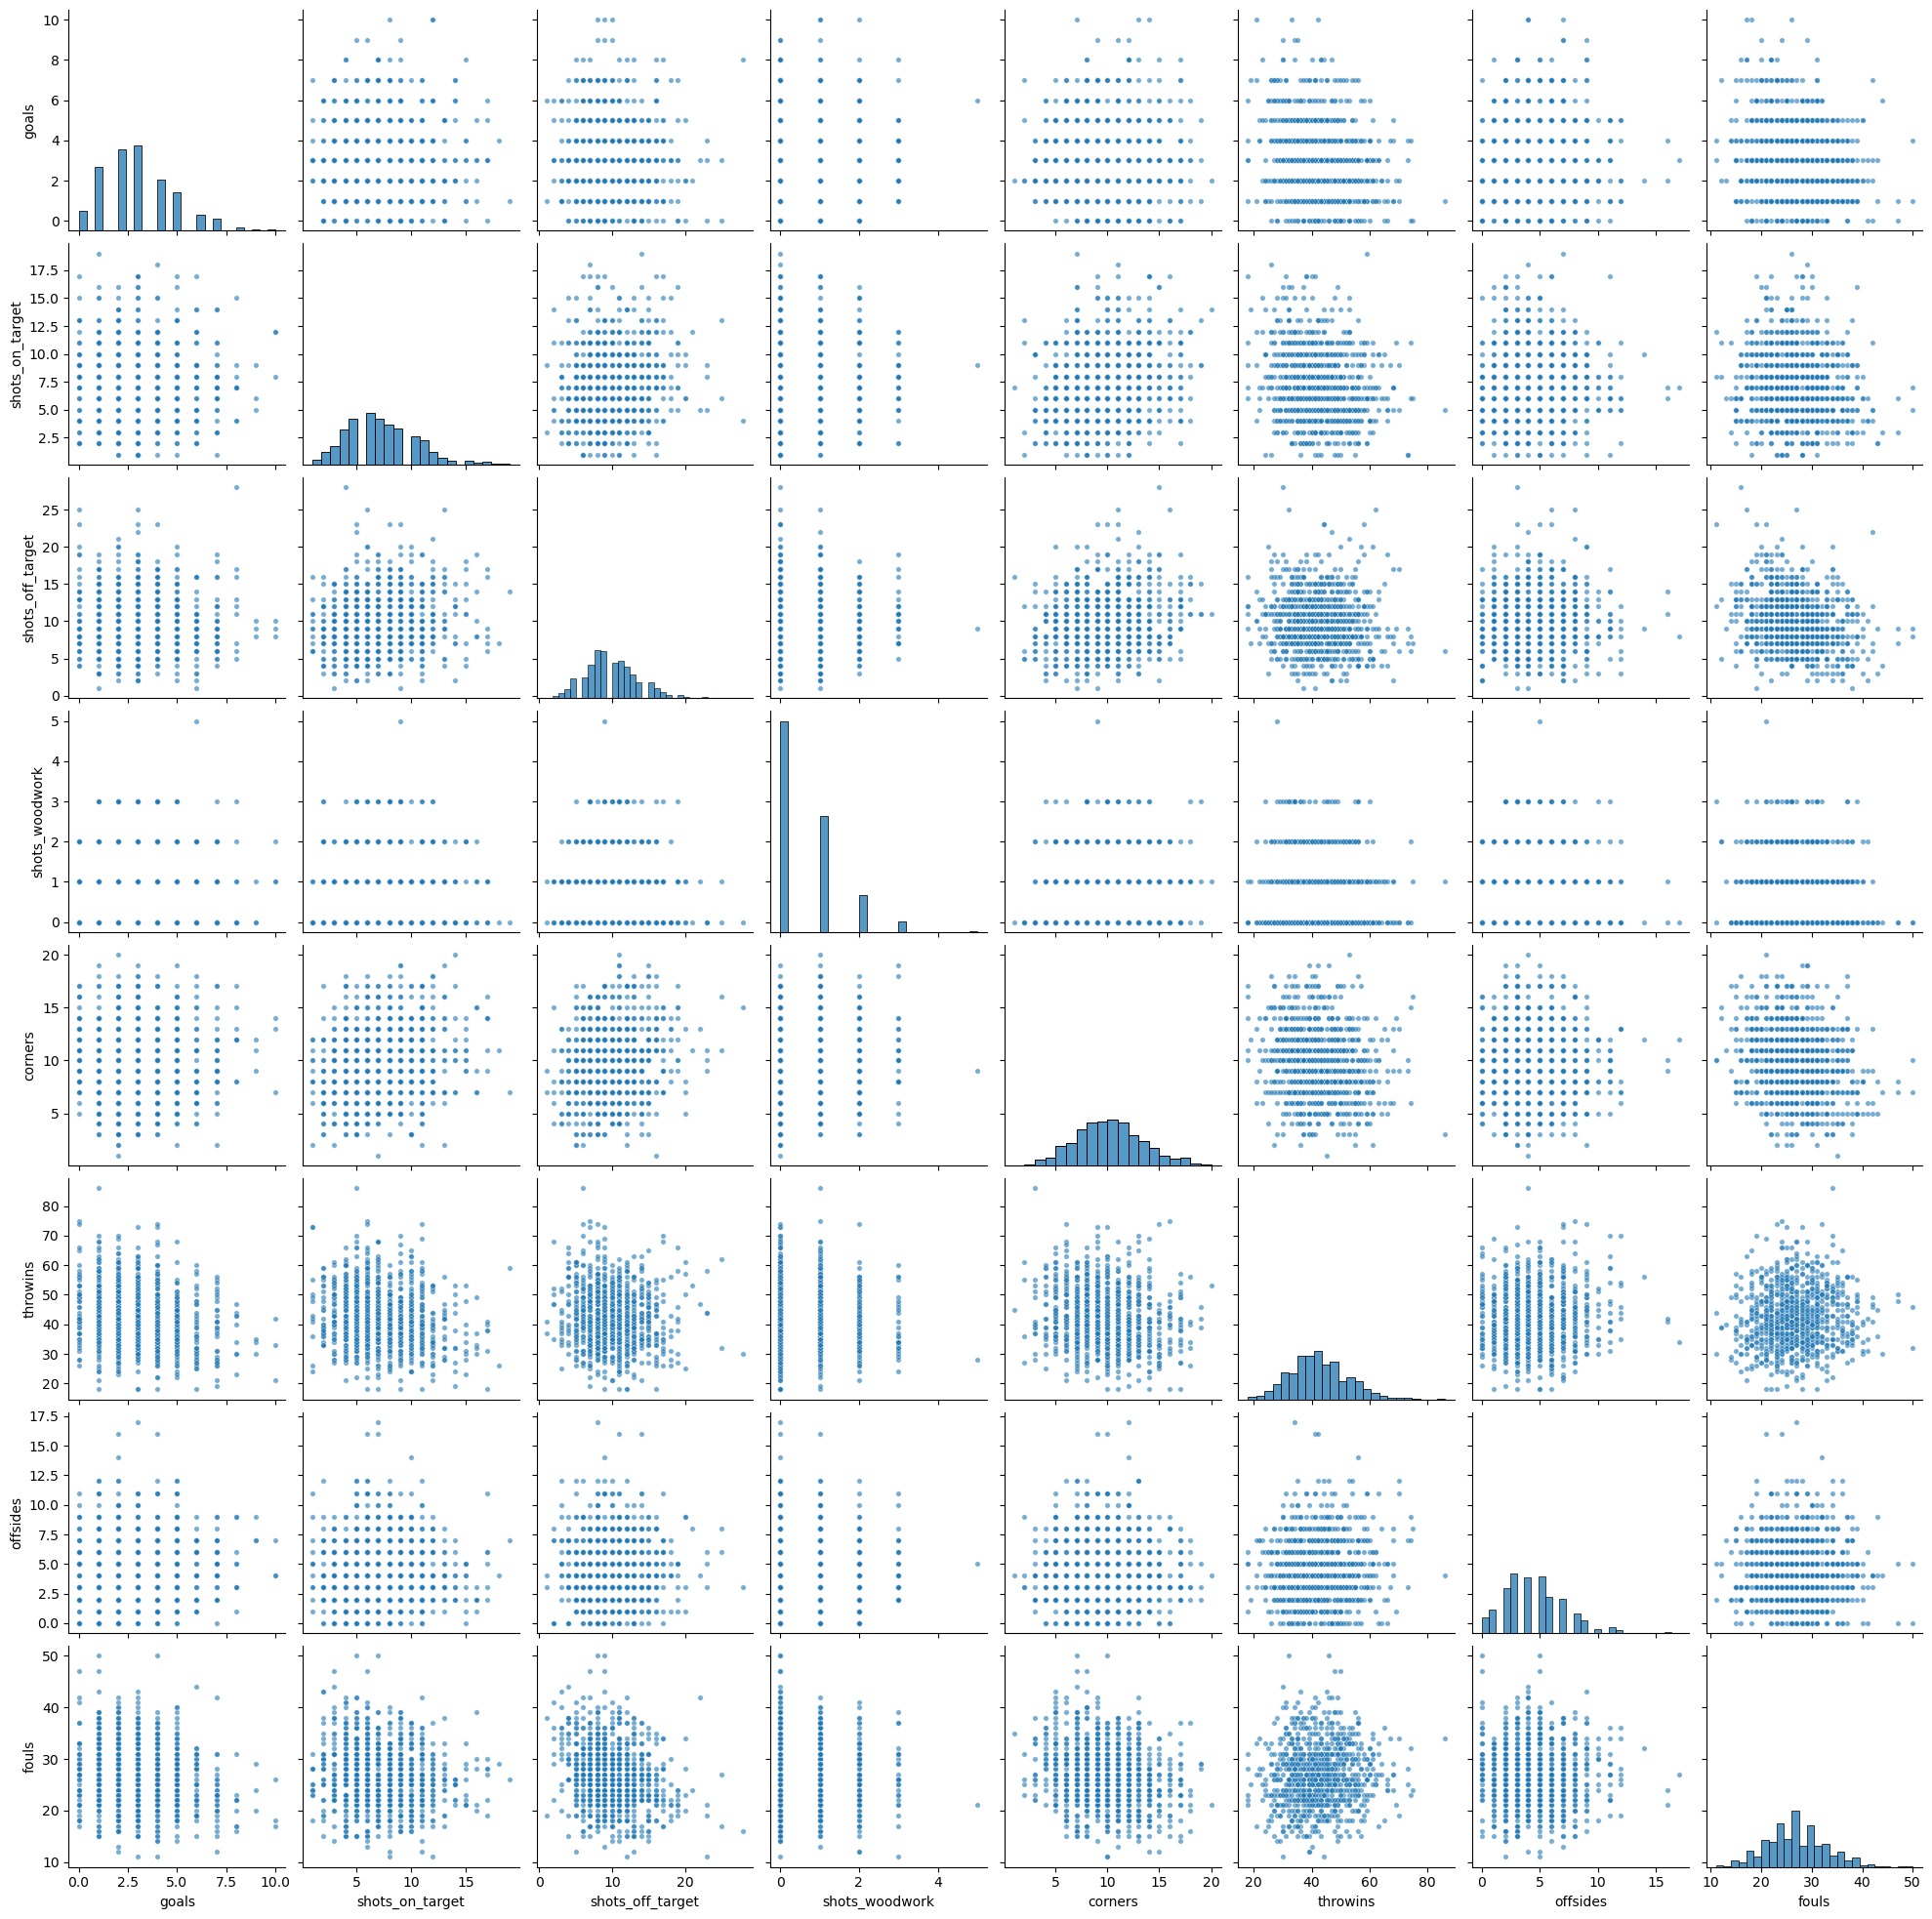

In [86]:
cols = ['goals', 'shots_on_target', 'shots_off_target', 'shots_woodwork', 'corners', 'throwins', 'offsides', 'fouls']

sns.pairplot(match_premier[cols], corner=False, plot_kws={"s": 15, "alpha": 0.6})
sns.pairplot(match_league1[cols], corner=False, plot_kws={"s": 15, "alpha": 0.6})
sns.pairplot(match_laliga[cols], corner=False, plot_kws={"s": 15, "alpha": 0.6})

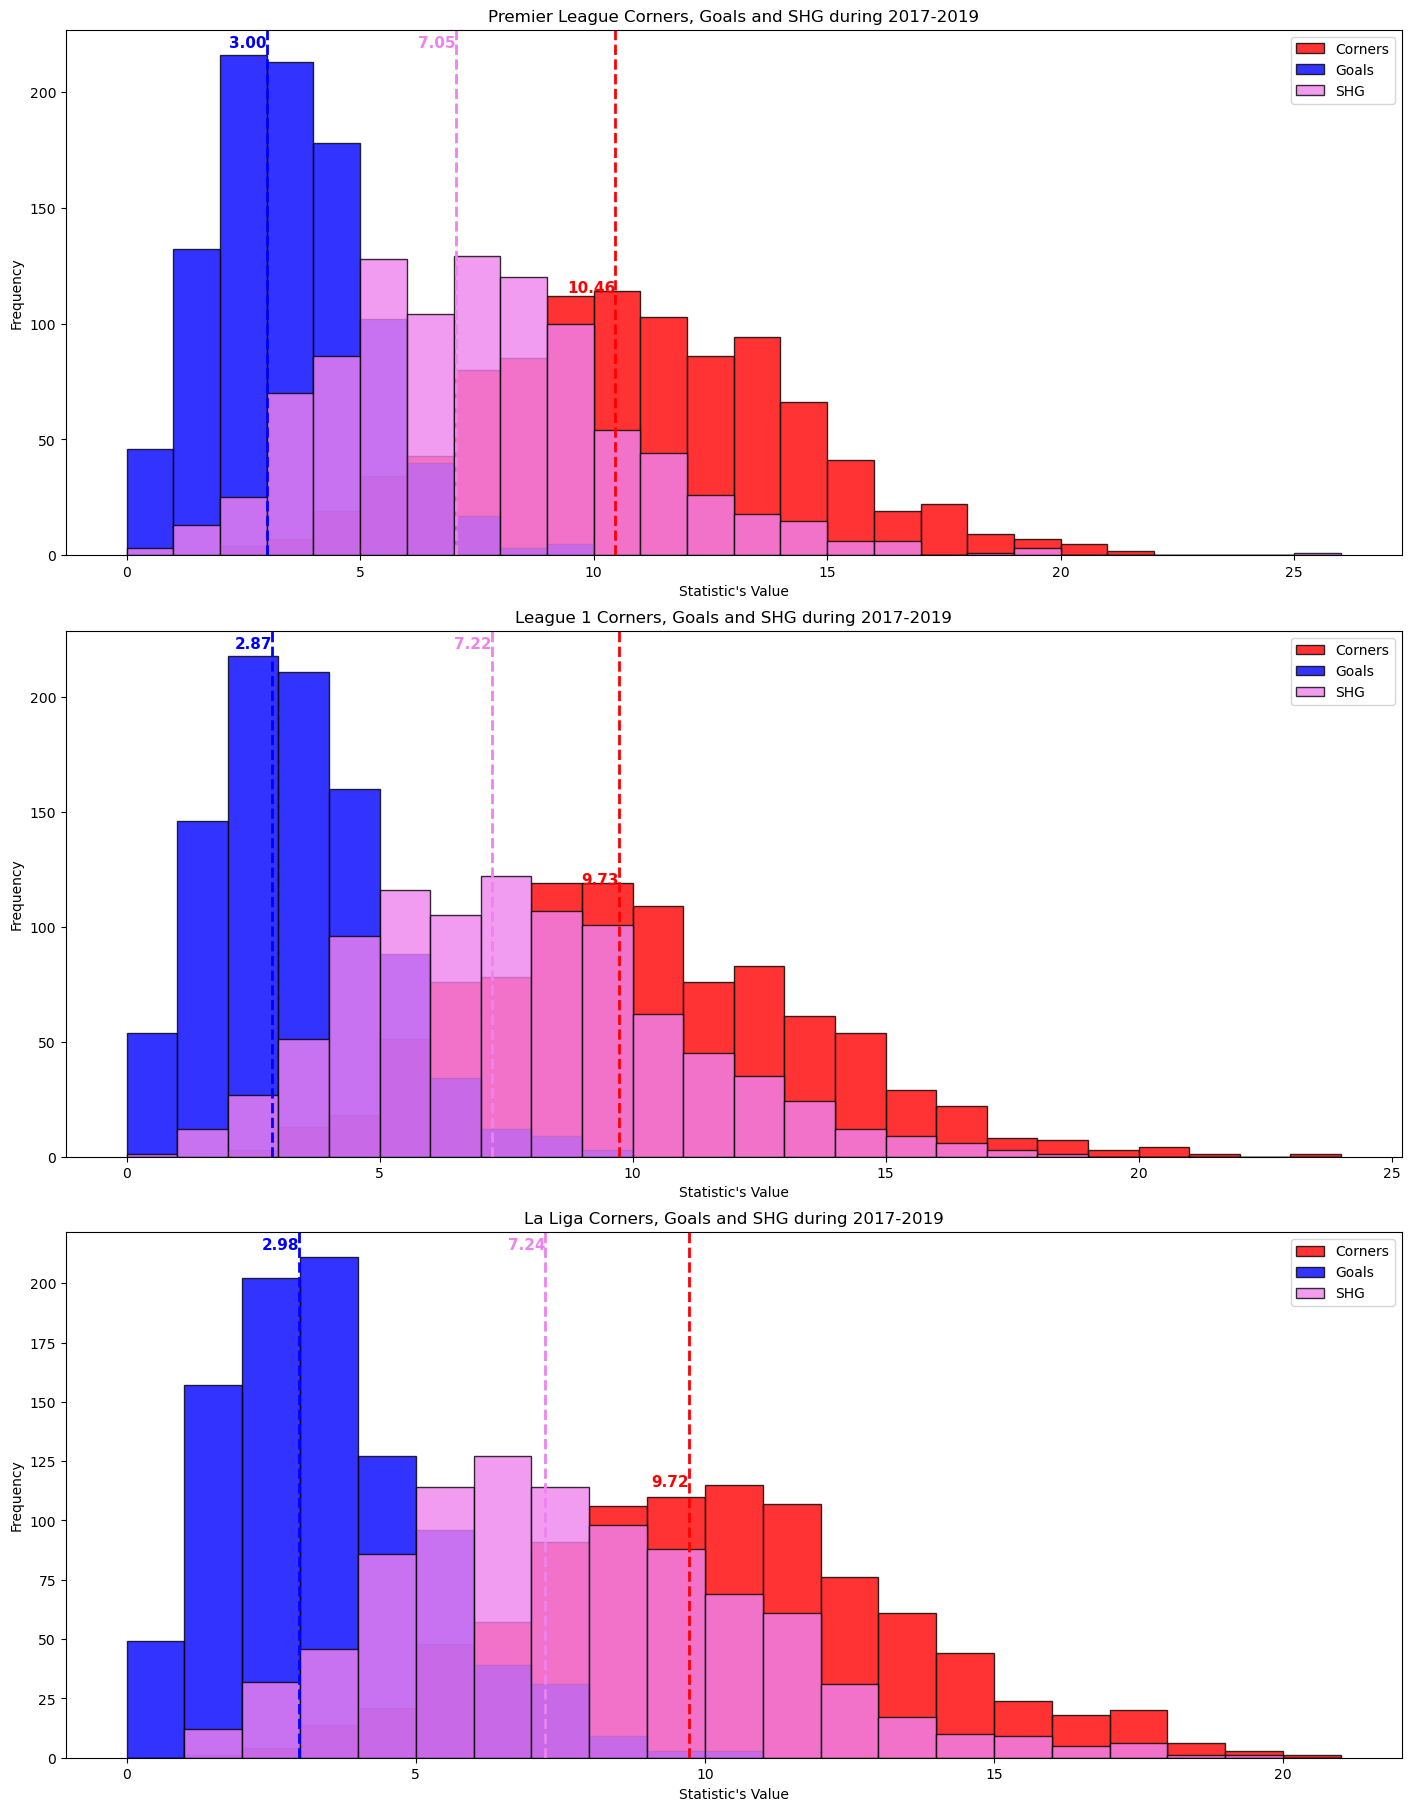

In [97]:
import matplotlib.pyplot as plt
import numpy as np

# Overlay histograms for three stats with mean lines per league (3x1)
leagues = [match_premier, match_league1, match_laliga]
labels = ["Premier League", "League 1", "La Liga"]
plot_cols = {
    "corners": {"color": "red"},
    "goals": {"color": "blue"},
    "shots_on_target": {"color": "violet"},  # SHG
}

fig, axes = plt.subplots(3, 1, figsize=(14, 18), constrained_layout=True)

for ax, league_df, title in zip(axes, leagues, labels):
    # Compute common bin edges based on all selected columns to align bars
    data_min = min(league_df[c].min() for c in plot_cols.keys())
    data_max = max(league_df[c].max() for c in plot_cols.keys())
    # Use integer bins from min to max; adjust step if distribution is sparse/dense
    bins = np.arange(int(data_min), int(data_max) + 2)  # +2 so last bin includes max

    # Plot histograms
    for col, style in plot_cols.items():
        ax.hist(
            league_df[col],
            bins=bins,
            alpha=0.8,
            label=col.replace("_", " ").title() if col != "shots_on_target" else "SHG",
            color=style["color"],
            edgecolor="black",
        )

        # Mean lines and labels
        mean_val = league_df[col].mean()
        ax.axvline(mean_val, color=style["color"], linestyle="--", linewidth=2)
        # Place a text label slightly above the tallest bar; fallback y if empty
        y_max = ax.get_ylim()[1]
        ax.text(
            mean_val,
            y_max * 0.99,
            f"{mean_val:.2f}",
            color=style["color"],
            ha="right",
            va="top",
            fontsize=11,
            fontweight="bold",
        )

    ax.set_title(f"{title} Corners, Goals and SHG during 2017-2019")
    ax.set_xlabel("Statistic's Value")
    ax.set_ylabel("Frequency")
    ax.legend(loc="upper right")

plt.show()


# Check what distribution best follows our data (e.g corners, throw ins, goals) for variation purposes

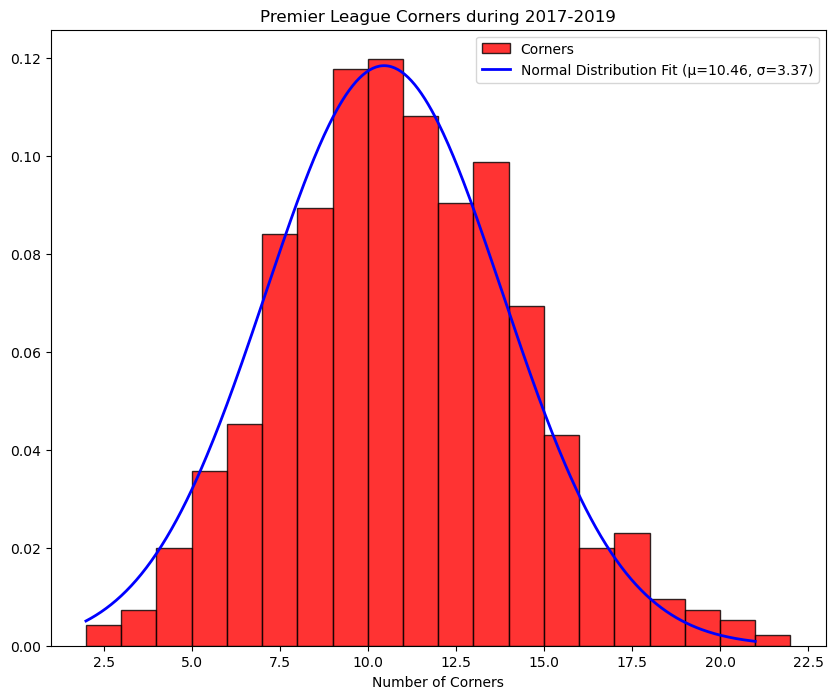

In [114]:
from scipy.stats import norm
import math

def normal_pdf(x, mu, sigma):
    return (1.0 / (sigma * math.sqrt(2 * math.pi))) * math.exp(-0.5 * ((x - mu) / sigma) ** 2)

def plot_gaussian_fit(series, ax, color_curve = "black", label_curve="Normal fit"):
    x = pd.to_numeric(series, errors='coerce').dropna().values
    if x.size == 0:
        return # No data to fit
    mu = x.mean()
    sigma = x.std()

    if sigma == 0:
        return  # Avoid division by zero
    x_min, x_max = x.min(), x.max()
    x_values = np.linspace(x_min, x_max, 400)
    y_values = norm.pdf(x_values, mu, sigma)
    ax.plot(x_values, y_values, color=color_curve, linewidth=2, label=f"{label_curve} (μ={mu:.2f}, σ={sigma:.2f})")


plt.figure(figsize=(10, 8))


min_data = int(match_premier.corners.min())
max_data = int(match_premier.corners.max())
bins = np.arange(min_data, max_data + 2)  # +2 to include max in last bin
plt.hist(
    match_premier.corners,
    bins=bins,
    alpha=0.8,
    label="Corners",
    color="red",
    edgecolor="black",
    density=True  # use density=True to normalize the histogram
)
plot_gaussian_fit(match_premier.corners, plt.gca(), color_curve="blue", label_curve="Normal Distribution Fit")
plt.title("Premier League Corners during 2017-2019")
plt.xlabel("Number of Corners")
plt.legend()
plt.show()

## Distribution build functions

In [137]:
# --- Binomial PMF ---
def binomial_pmf(k_vals, n, p):
    k_vals = np.asarray(k_vals, dtype=int)
    return binom.pmf(k_vals, n=n, p=p)

# --- Estimate Binomial parameters ---
def estimate_binomial_params(x):
    n = int(x.max())  # max number of trials (can tweak)
    if n == 0:
        n = 1
    p = np.mean(x) / n
    p = min(max(p, 1e-6), 1-1e-6)  # ensure 0 < p < 1
    return n, p
# --- PMF/PDF functions ---
def plot_gaussian_fit(series, ax, color_curve = "black", label_curve="Normal fit"):
    x = pd.to_numeric(series, errors='coerce').dropna().values
    if x.size == 0:
        return # No data to fit
    mu = x.mean()
    sigma = x.std()

    if sigma == 0:
        return  # Avoid division by zero
    x_min, x_max = x.min(), x.max()
    x_values = np.linspace(x_min, x_max, 400)
    y_values = norm.pdf(x_values, mu, sigma)
    ax.plot(x_values, y_values, color=color_curve, linewidth=2, label=f"{label_curve} (μ={mu:.2f}, σ={sigma:.2f})")

def poisson_pmf(k_vals, lam):
    k_vals = np.asarray(k_vals, dtype=int)
    return poisson.pmf(k_vals, mu=lam)


def negbinom_pmf(k_vals, r, p):
    k_vals = np.asarray(k_vals, dtype=int)
    return nbinom.pmf(k_vals, n=r, p=p)


def gaussian_mixture_pdf(x_vals, w, mu1, sigma1, mu2, sigma2):
    return w * norm.pdf(x_vals, mu1, sigma1) + (1 - w) * norm.pdf(x_vals, mu2, sigma2)

# Log-normal PDF and parameter estimation (SciPy)
from scipy.stats import lognorm

def estimate_lognormal_params(x):
    # Fit log-normal via MLE: returns shape (sigma), loc, scale
    # We constrain loc=0 for count data; handle zeros by shifting or filtering
    x = np.asarray(x, dtype=float)
    x = x[x > 0]  # log-normal defined for x>0
    if x.size < 2:
        return None
    shape, loc, scale = lognorm.fit(x, floc=0)  # fix loc=0
    return shape, scale

def lognormal_pdf(x_vals, shape, scale):
    return lognorm.pdf(x_vals, s=shape, scale=scale)

# --- Parameter estimation helpers ---

def estimate_poisson_lambda(x):
    return float(np.mean(x))


def estimate_negbinom_params(x):
    m = float(np.mean(x))
    v = float(np.var(x, ddof=0))
    if v <= m or m == 0:
        r = 10.0
        p = r / (r + max(m, 1e-6))
    else:
        r = (m * m) / (v - m)
        p = r / (r + m)
    return r, p

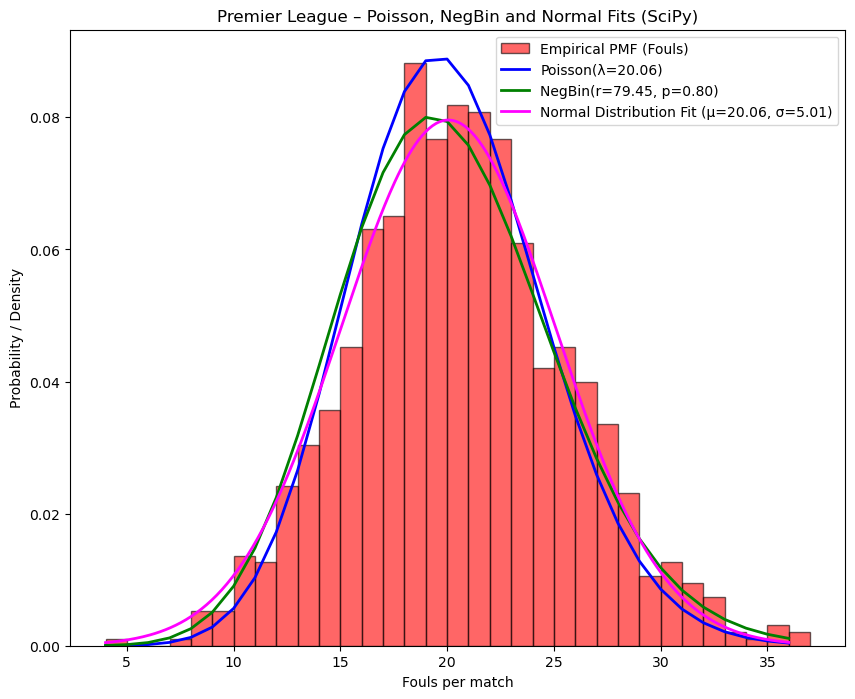

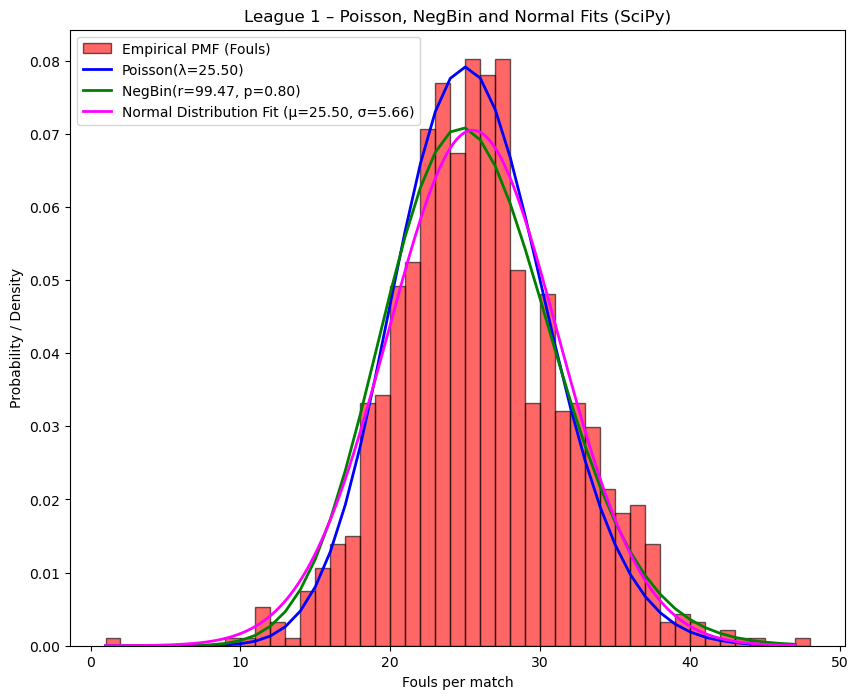

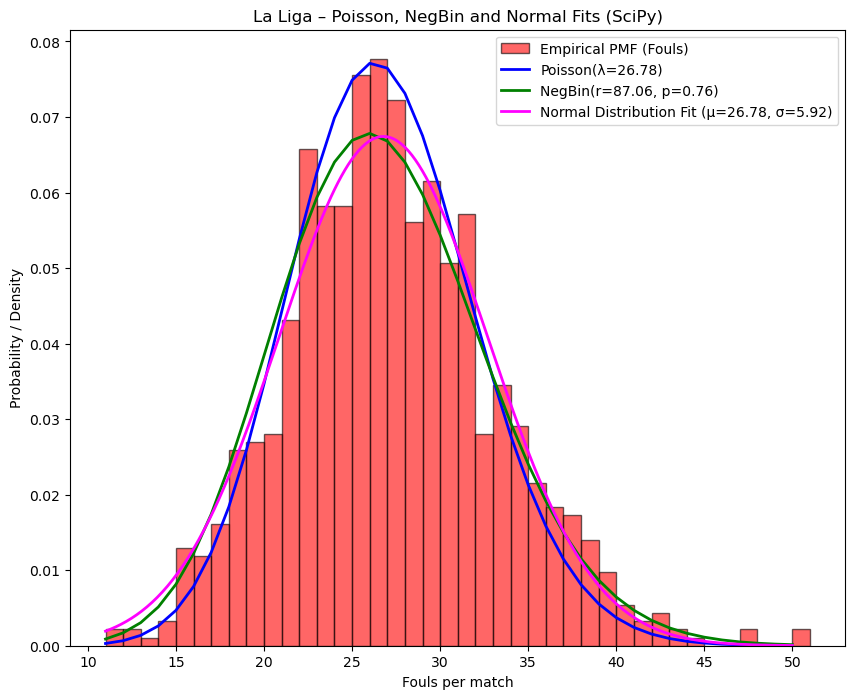

In [140]:
# Poisson, Negative Binomial, Normal, and Log-Normal fits (SciPy-only)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson, nbinom, norm, binom, lognorm


leagues = [match_premier, match_league1, match_laliga]
labels = ["Premier League", "League 1", "La Liga"]

for league, label in zip(leagues,labels):
    # --- Demo overlay on fouls ---
    series = pd.to_numeric(league.fouls, errors="coerce").dropna().astype(int)
    if series.size > 0:
        # Empirical PMF (bars sum to 1)
        k_min, k_max = int(series.min()), int(series.max())
        bins = np.arange(k_min, k_max + 2)
        weights = np.ones(series.size) / series.size

        plt.figure(figsize=(10, 8))
        plt.hist(series, bins=bins, align="mid", weights=weights, color="red", alpha=0.6, edgecolor="black", label="Empirical PMF (Fouls)")

        # Poisson fit
        lam = estimate_poisson_lambda(series.values)
        k_grid = np.arange(k_min, k_max + 1)
        pois = poisson_pmf(k_grid, lam)
        plt.plot(k_grid, pois, color="blue", linewidth=2, label=f"Poisson(λ={lam:.2f})")

        # Negative Binomial fit
        r, p = estimate_negbinom_params(series.values)
        nb = negbinom_pmf(k_grid, r, p)
        plt.plot(k_grid, nb, color="green", linewidth=2, label=f"NegBin(r={r:.2f}, p={p:.2f})")

        # Normal fit (continuous)
        plot_gaussian_fit(league.fouls, plt.gca(), color_curve="magenta", label_curve="Normal Distribution Fit")


        plt.title(f"{label} – Poisson, NegBin and Normal Fits (SciPy)")
        plt.xlabel("Fouls per match")
        plt.ylabel("Probability / Density")
        plt.legend()
        plt.show()
    else:
        print("No data available to fit models.")


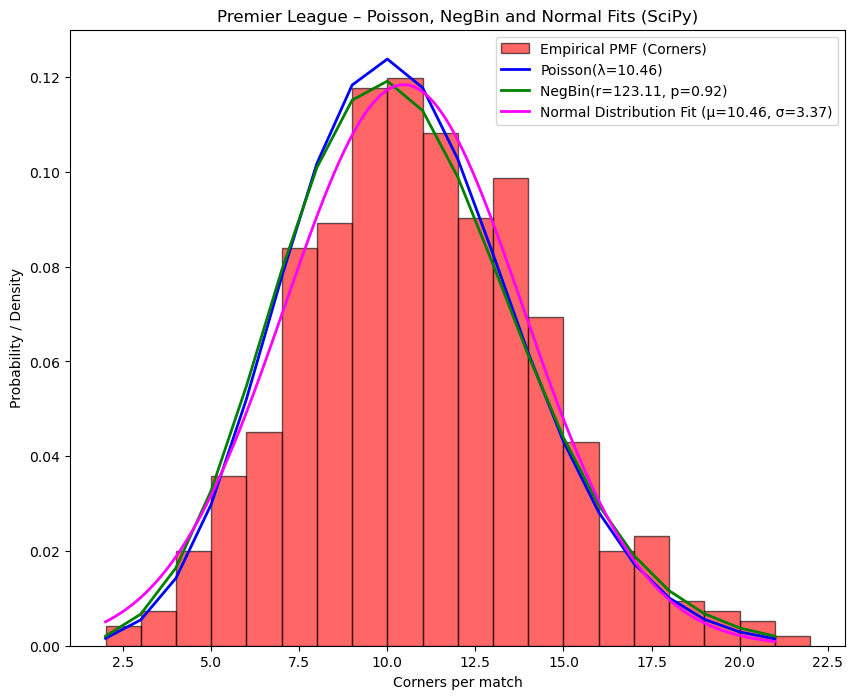

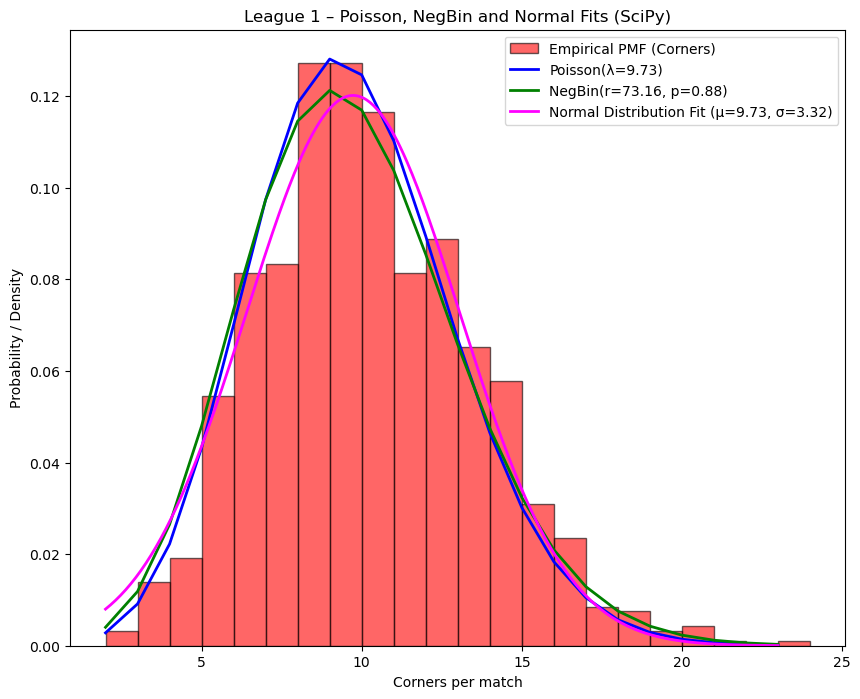

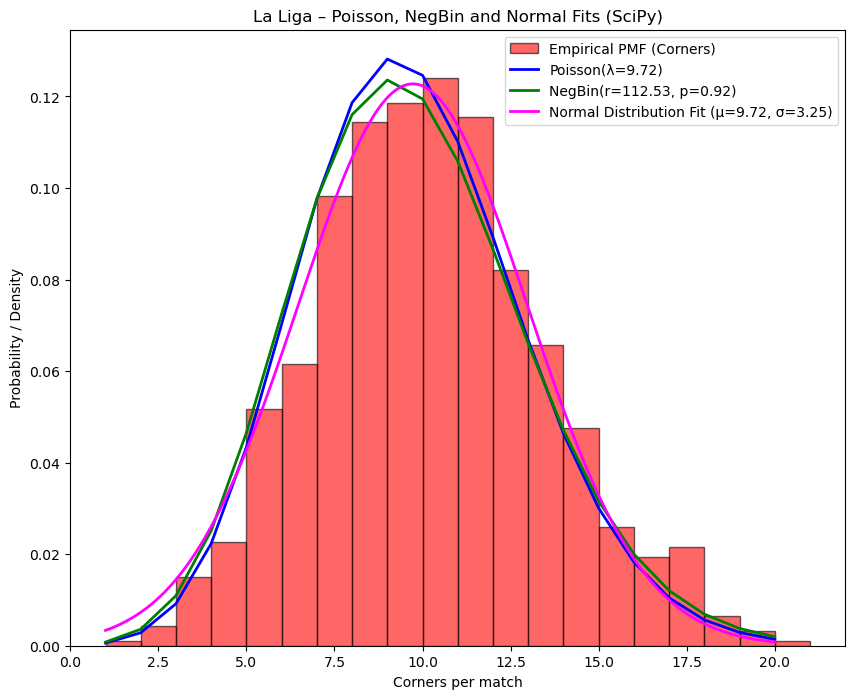

In [141]:
# Poisson, Negative Binomial, Normal, and Log-Normal fits (SciPy-only)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson, nbinom, norm, binom, lognorm

leagues = [match_premier, match_league1, match_laliga]
labels = ["Premier League", "League 1", "La Liga"]

for league, label in zip(leagues,labels):
    # --- Demo overlay on corners ---
    series = pd.to_numeric(league.corners, errors="coerce").dropna().astype(int)
    if series.size > 0:
        # Empirical PMF (bars sum to 1)
        k_min, k_max = int(series.min()), int(series.max())
        bins = np.arange(k_min, k_max + 2)
        weights = np.ones(series.size) / series.size

        plt.figure(figsize=(10, 8))
        plt.hist(series, bins=bins, align="mid", weights=weights, color="red", alpha=0.6, edgecolor="black", label="Empirical PMF (Corners)")

        # Poisson fit
        lam = estimate_poisson_lambda(series.values)
        k_grid = np.arange(k_min, k_max + 1)
        pois = poisson_pmf(k_grid, lam)
        plt.plot(k_grid, pois, color="blue", linewidth=2, label=f"Poisson(λ={lam:.2f})")

        # Negative Binomial fit
        r, p = estimate_negbinom_params(series.values)
        nb = negbinom_pmf(k_grid, r, p)
        plt.plot(k_grid, nb, color="green", linewidth=2, label=f"NegBin(r={r:.2f}, p={p:.2f})")

        # Normal fit (continuous)
        plot_gaussian_fit(league.corners, plt.gca(), color_curve="magenta", label_curve="Normal Distribution Fit")



        plt.title(f"{label} – Poisson, NegBin and Normal Fits (SciPy)")
        plt.xlabel("Corners per match")
        plt.ylabel("Probability / Density")
        plt.legend()
        plt.show()
    else:
        print("No data available to fit models.")


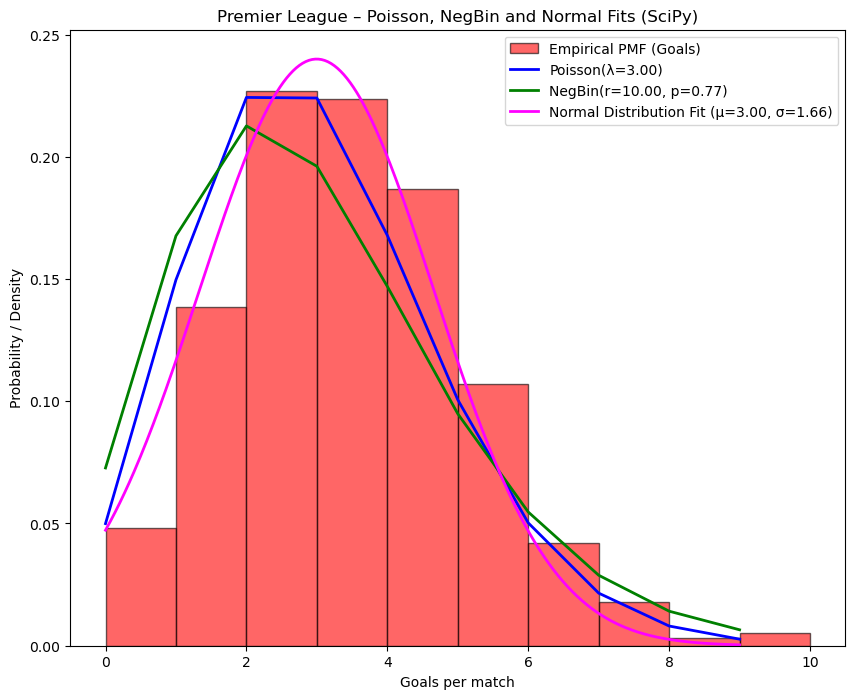

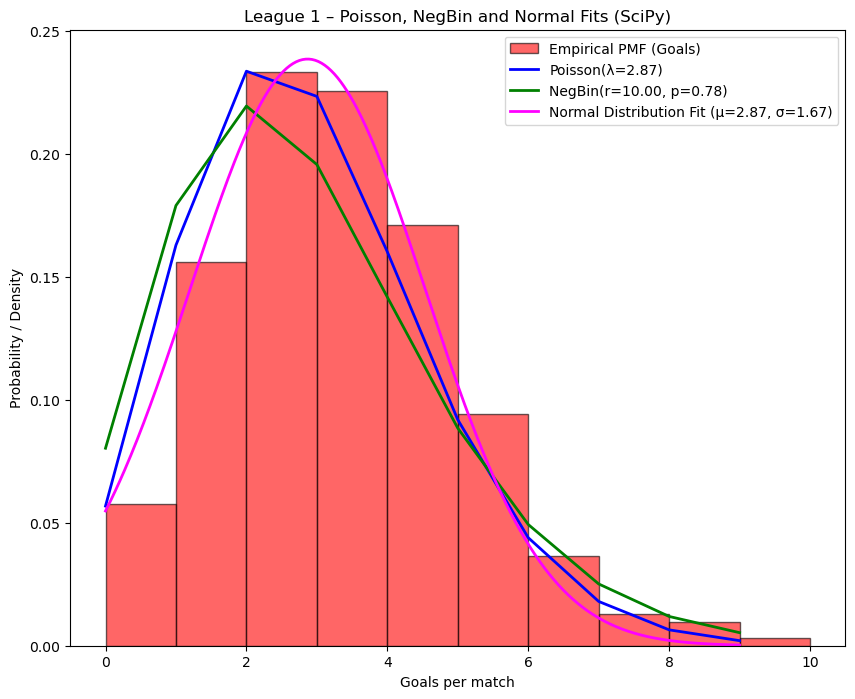

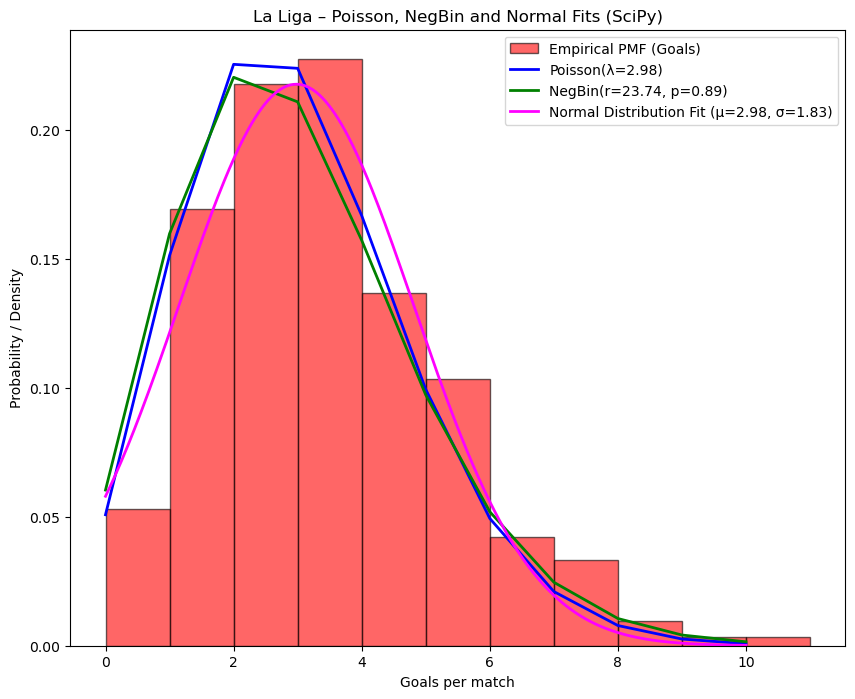

In [142]:
# Poisson, Negative Binomial, Normal, and Log-Normal fits (SciPy-only)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson, nbinom, norm, binom, lognorm


leagues = [match_premier, match_league1, match_laliga]
labels = ["Premier League", "League 1", "La Liga"]

for league, label in zip(leagues,labels):
    # --- Demo overlay on corners ---
    series = pd.to_numeric(league.goals, errors="coerce").dropna().astype(int)
    if series.size > 0:
        # Empirical PMF (bars sum to 1)
        k_min, k_max = int(series.min()), int(series.max())
        bins = np.arange(k_min, k_max + 2)
        weights = np.ones(series.size) / series.size

        plt.figure(figsize=(10, 8))
        plt.hist(series, bins=bins, align="mid", weights=weights, color="red", alpha=0.6, edgecolor="black", label="Empirical PMF (Goals)")

        # Poisson fit
        lam = estimate_poisson_lambda(series.values)
        k_grid = np.arange(k_min, k_max + 1)
        pois = poisson_pmf(k_grid, lam)
        plt.plot(k_grid, pois, color="blue", linewidth=2, label=f"Poisson(λ={lam:.2f})")

        # Negative Binomial fit
        r, p = estimate_negbinom_params(series.values)
        nb = negbinom_pmf(k_grid, r, p)
        plt.plot(k_grid, nb, color="green", linewidth=2, label=f"NegBin(r={r:.2f}, p={p:.2f})")

        # Normal fit (continuous)
        plot_gaussian_fit(league.goals, plt.gca(), color_curve="magenta", label_curve="Normal Distribution Fit")

        plt.title(f"{label} – Poisson, NegBin and Normal Fits (SciPy)")
        plt.xlabel("Goals per match")
        plt.ylabel("Probability / Density")
        plt.legend()
        plt.show()
    else:
        print("No data available to fit models.")


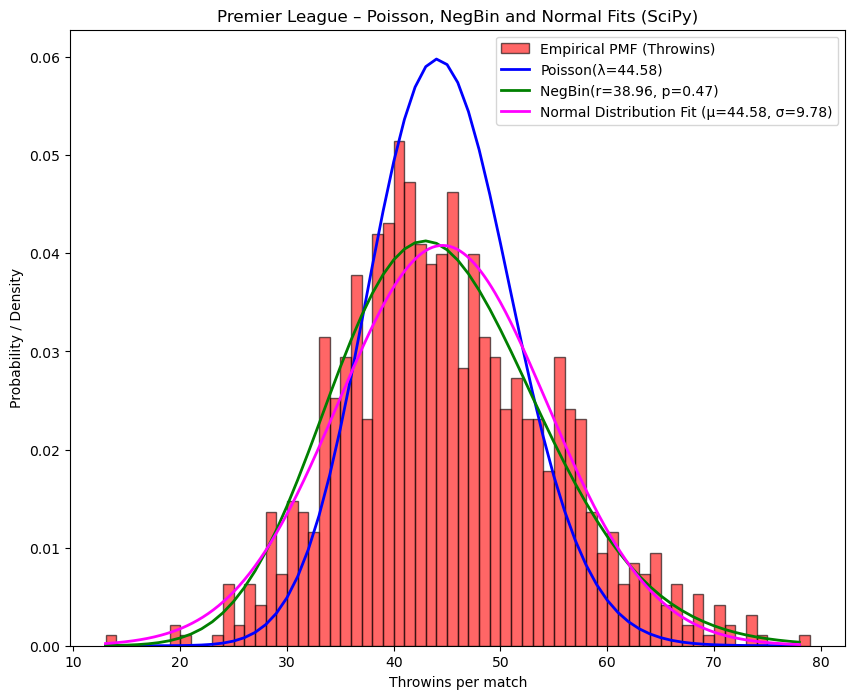

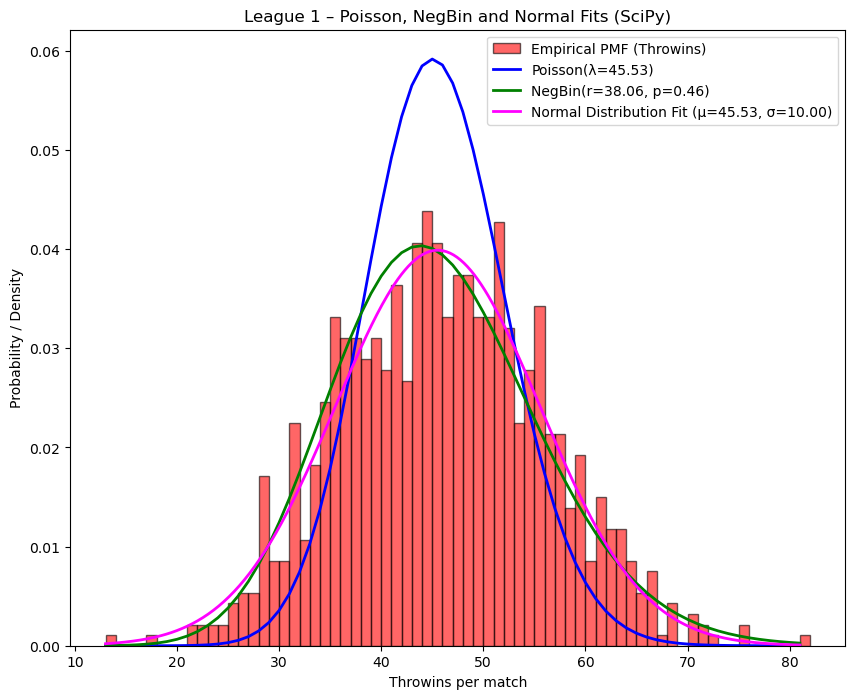

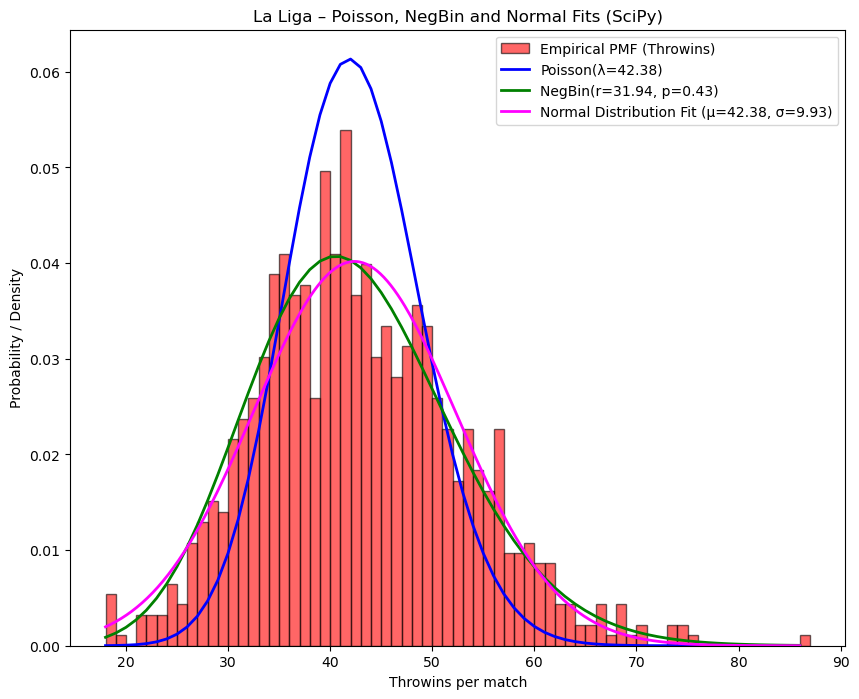

In [143]:
# Poisson, Negative Binomial, Normal, and Log-Normal fits (SciPy-only)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson, nbinom, norm, binom, lognorm


leagues = [match_premier, match_league1, match_laliga]
labels = ["Premier League", "League 1", "La Liga"]

for league, label in zip(leagues,labels):
    # --- Demo overlay on corners ---
    series = pd.to_numeric(league.throwins, errors="coerce").dropna().astype(int)
    if series.size > 0:
        # Empirical PMF (bars sum to 1)
        k_min, k_max = int(series.min()), int(series.max())
        bins = np.arange(k_min, k_max + 2)
        weights = np.ones(series.size) / series.size

        plt.figure(figsize=(10, 8))
        plt.hist(series, bins=bins, align="mid", weights=weights, color="red", alpha=0.6, edgecolor="black", label="Empirical PMF (Throwins)")

        # Poisson fit
        lam = estimate_poisson_lambda(series.values)
        k_grid = np.arange(k_min, k_max + 1)
        pois = poisson_pmf(k_grid, lam)
        plt.plot(k_grid, pois, color="blue", linewidth=2, label=f"Poisson(λ={lam:.2f})")

        # Negative Binomial fit
        r, p = estimate_negbinom_params(series.values)
        nb = negbinom_pmf(k_grid, r, p)
        plt.plot(k_grid, nb, color="green", linewidth=2, label=f"NegBin(r={r:.2f}, p={p:.2f})")

        # Normal fit (continuous)
        plot_gaussian_fit(league.throwins, plt.gca(), color_curve="magenta", label_curve="Normal Distribution Fit")

        plt.title(f"{label} – Poisson, NegBin and Normal Fits (SciPy)")
        plt.xlabel("Throwins per match")
        plt.ylabel("Probability / Density")
        plt.legend()
        plt.show()
    else:
        print("No data available to fit models.")
